# 🎨 Part 2: Guided Generation and Control in Pretrained Diffusion Models

### Name: Muhammad Ahmad
### Roll number: 26100398

## 🚀 Objectives:
- Use pretrained **Stable Diffusion** for text-to-image generation
- Experiment with **guidance scales** and **prompt engineering**
- Explore **inpainting**
- Explore **Style Transfer**

---

## 🧰 Setup

> Run the cell below to install the necessary libraries: `diffusers`, `transformers`, `accelerate`, `safetensors`, `xformers`, and `controlnet_aux`.

These libraries will enable us to use pre-trained diffusion models and speed up inference using GPU acceleration.



In [1]:
!pip install --upgrade diffusers transformers accelerate safetensors xformers controlnet_aux --quiet



# 🧪 Task 1: Classifier-Free Guidance in Stable Diffusion

In diffusion-based generative models, **Classifier-Free Guidance (CFG)** is a technique used to steer the generation process toward better image-text alignment without requiring an external classifier.

Here's how it works:
- During training, the model occasionally replaces the text condition with an empty string (i.e., unconditional).
- At inference time, it combines the conditional and unconditional predictions to guide the sample.
  
The guidance formula is:\
prediction = uncond + scale * (cond - uncond)


Where:
- `cond` is the model's prediction with the prompt.
- `uncond` is the model's prediction without the prompt.
- `scale` (a float) controls the strength of the guidance.

A higher `guidance_scale` encourages the model to follow the prompt more closely, possibly at the cost of image diversity.




In [2]:
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"


### ⚙️ Step 1: Load a Pretrained Stable Diffusion Model

Use `diffusers` from HuggingFace to load a pretrained Stable Diffusion pipeline.

📌 Your task:
- Load the `"runwayml/stable-diffusion-v1-5"` model.
- Set the pipeline to use `torch_dtype=torch.float16`.
- Move the model to `"cuda"` and enable attention slicing for memory efficiency.

### 🎛️ Step 2: Implement CFG Sampling

Define a function that:
- Takes a prompt and a guidance scale.
- Uses the pipeline to generate an image with the given CFG value.
- Returns the generated image.

📌 This is your **CFG sampler**.


In [13]:


model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)

pipe = pipe.to("cuda")
pipe.enable_attention_slicing()
def generate_image(prompt: str, guidance_scale: float):

    image = pipe(prompt=prompt, guidance_scale=guidance_scale).images[0]
    return image


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 🧪 Step 3: Analyze the Effect of CFG

Use your `generate_with_cfg` function to generate images for the same prompt with **different guidance scales**.

- Prompt: `"a futuristic cityscape at night"`
- Try values of `guidance_scale`: `[1.0, 5.0, 7.5, 12.0]`
- Try a prompt by yourself too

🎨 Display the results in a horizontal row of subplots.
- Add titles showing the CFG scale.
- Hide the axes.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

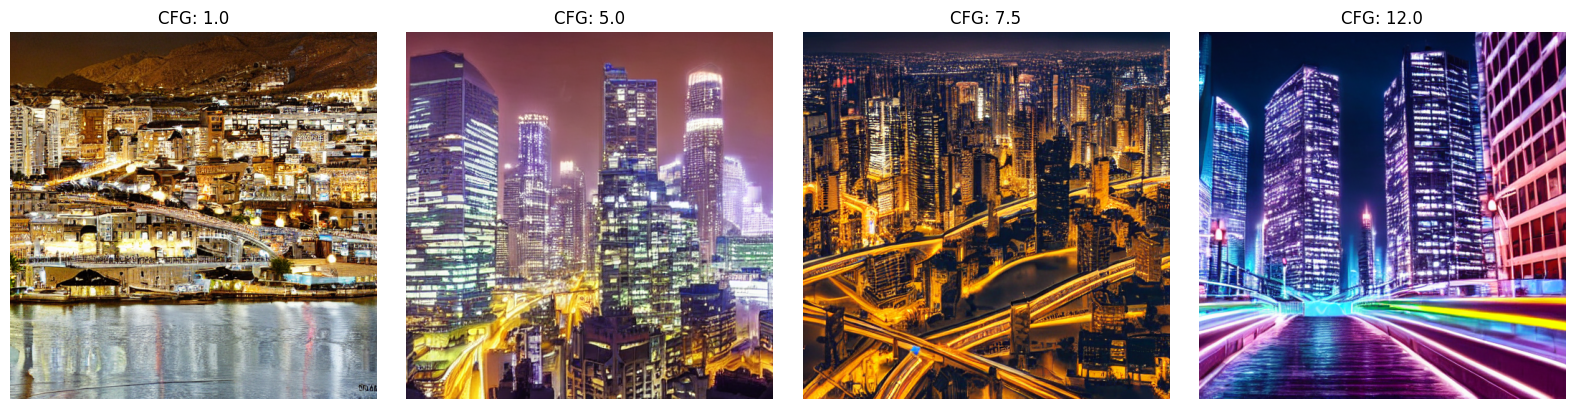

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

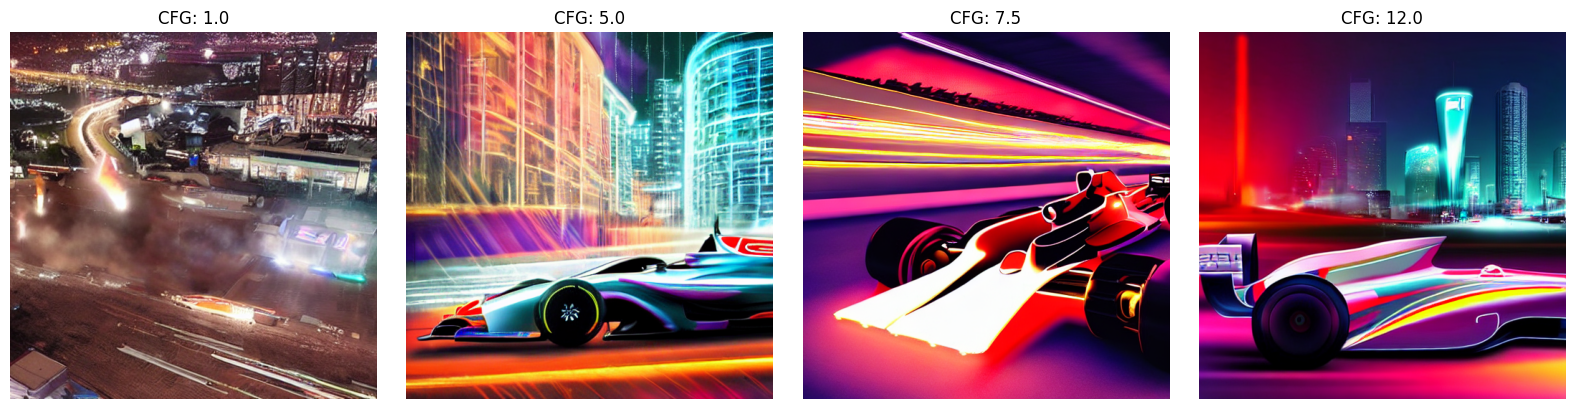

In [14]:

prompt = "a futuristic cityscape at night"
guidance_scales = [1.0, 5.0, 7.5, 12.0]

images = [generate_image(prompt, scale) for scale in guidance_scales]

plt.figure(figsize=(16, 4))
for i, (img, scale) in enumerate(zip(images, guidance_scales)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.title(f"CFG: {scale}")
    plt.axis("off")
plt.tight_layout()
plt.show()

custom_prompt = " futuristic Formula 1 race car speeding through a neon-lit city"
custom_scales = [1.0, 5.0, 7.5, 12.0]

custom_images = [generate_image(custom_prompt, scale) for scale in custom_scales]

plt.figure(figsize=(16, 4))
for i, (img, scale) in enumerate(zip(custom_images, custom_scales)):
    plt.subplot(1, len(custom_images), i + 1)
    plt.imshow(img)
    plt.title(f"CFG: {scale}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# 🧩 Task 2: Image Inpainting with Diffusion Models

## What is Inpainting?

**Image Inpainting** is the task of filling in missing or masked-out regions in an image in a way that is coherent and visually plausible. Diffusion models like Stable Diffusion can do this by generating new content in a masked region based on a text prompt.

You provide:
- A **base image** (with a region you want to edit)
- A **binary mask** (white = area to fill, black = area to preserve)
- A **prompt** describing what should appear in the masked region

---

## Classifier-Free Guidance (CFG) in Inpainting

Just like in text-to-image generation, **Classifier-Free Guidance (CFG)** is used to control how strictly the model follows the text prompt during inpainting. A higher `guidance_scale` forces the model to match the prompt more strongly but may sacrifice image quality or realism.



### 🧰 Step 1: Load Stable Diffusion Inpainting Pipeline

Use `StableDiffusionInpaintPipeline` from HuggingFace's `diffusers` library.

📌 Your task:
- Load the pretrained model: `"stabilityai/stable-diffusion-2-inpainting"`.
- Use the `fp16` revision.
- Set `torch_dtype` to `float16` and move it to `"cuda"`.
- Disable the `safety_checker` for faster setup.

Refer to the HuggingFace documentation or examples for help.

In [5]:

inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker=None
)


inpaint_pipe = inpaint_pipe.to("cuda")

inpaint_pipe.enable_attention_slicing()


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-inpainting currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-inpainting is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transf

### 🔎 Step 2: Find an Image and a Mask

❗ You must find your own **image and corresponding binary mask**.

Requirements:
- The image must be **RGB** and resized to **512x512**.
- The mask should be a **black-and-white image** (white = inpaint area).
- Use any source: upload your own, or use URLs from a dataset or search.

📌 Load both using `PIL.Image`, convert to RGB (for image) and resize both to `(512, 512)`.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


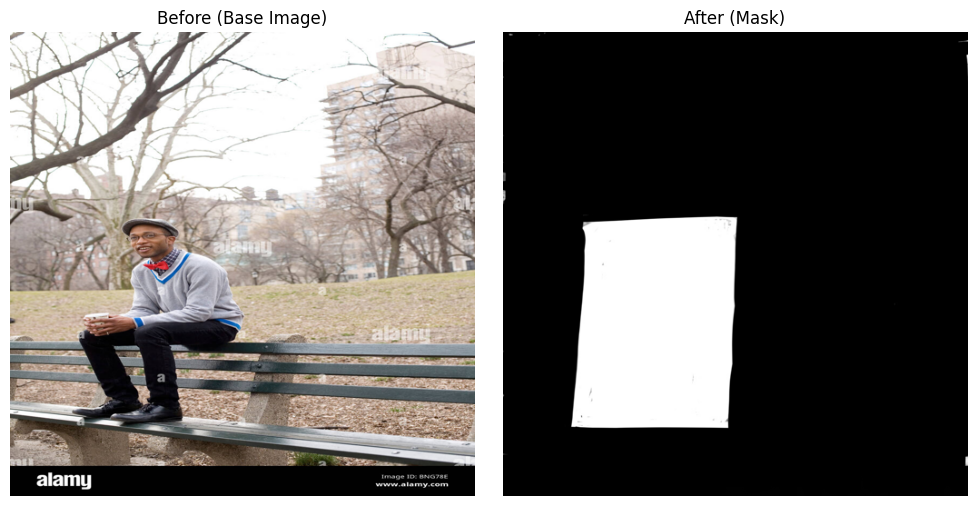

In [16]:
from google.colab import drive
import os
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/"
image_path = os.path.join(base_path, "man.jpg")
mask_path = os.path.join(base_path, "man2.jpg")


def load_and_resize(path, mode="RGB", size=(512, 512)):
    img = Image.open(path).convert(mode)
    return img.resize(size)

image = load_and_resize(image_path, mode="RGB")
mask = load_and_resize(mask_path, mode="L")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Before (Base Image)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("After (Mask)")
plt.axis("off")
plt.tight_layout()
plt.show()


### 🎨 Step 3: Inpaint the Masked Region

Use your inpainting pipeline to fill the masked region using a text prompt.

💬 Prompt idea: `"a futuristic object"` or `"a fantasy landscape"` (just an example)

Optional:
- Try different prompts to observe changes. (upto 3)
- comment on the guidance classifier value used and changes you observe.

Display the original and inpainted images together.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

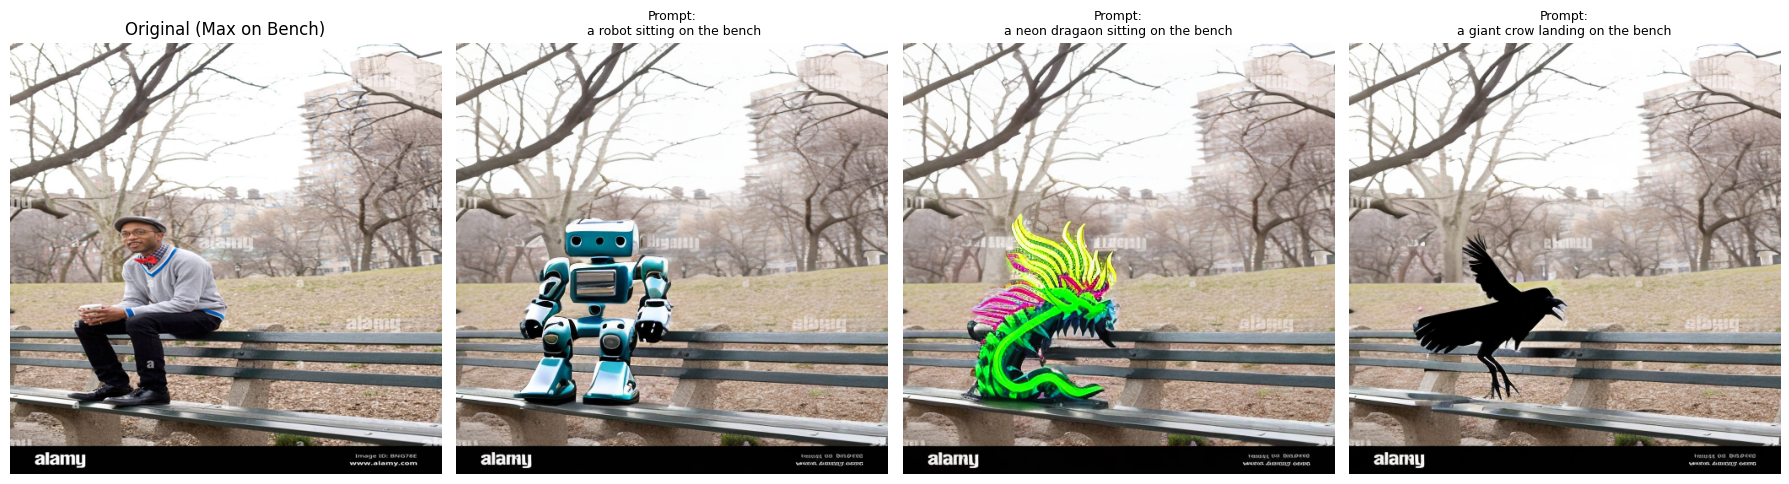

In [ ]:
def inpaint_image(prompt, image, mask, guidance_scale=7.5, steps=50):
    result = inpaint_pipe(
        prompt=prompt,
        image=image,
        mask_image=mask,
        guidance_scale=guidance_scale,
        num_inference_steps=steps
    )
    return result.images[0]

# Wild scene-changing prompts
prompts = [
    " a robot sitting on the bench",
    "a neon dragaon sitting on the bench",
    "a giant crow landing on the bench"
]

guidance_scale = 7.5
generated_images = [inpaint_image(p, image, mask, guidance_scale) for p in prompts]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, len(prompts) + 1, 1)
plt.imshow(image)
plt.title("Original (Max on Bench)")
plt.axis("off")

# Generated images
for i, (gen_img, p) in enumerate(zip(generated_images, prompts), 1):
    plt.subplot(1, len(prompts) + 1, i + 1)
    plt.imshow(gen_img)
    plt.title(f"Prompt:\n{p}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

#A guidance scale of 7.5, strikes an ideal balance between the text prompt and freedom for the model to be creative.
#At lower guidance values (e.g., 3–5), the model tended to generate more random or loosely related results, often ignoring specific prompt details.
#At very high values (e.g., 10–15), the model became too rigid, leading to unnatural artifacts or forced compositions that looked overfitted to the prompt.

# 🎨 Task 3: Style Transfer using ControlNet + IP-Adapter

## What is Style Transfer?

**Style Transfer** refers to the process of applying the artistic style of one image (e.g., a painting) to the content of another image (e.g., a photograph), generating a visually coherent blend of both.

In this task, we combine:
- **ControlNet** to preserve the structure or edges of the original image.
- **IP-Adapter** to influence the visual style using a reference (style) image.

This gives us fine-grained control over **what** the image contains (via prompts and edge maps) and **how** it looks (via the style image).

---

### 🔗 Required Models

You must load the following pre-trained models from Hugging Face:

- 🔧 **ControlNet Canny Detector**:  
  [lllyasviel/sd-controlnet-canny](https://huggingface.co/lllyasviel/sd-controlnet-canny)

- 🖼️ **Base Stable Diffusion Model (Absolute Reality)**:  
  [Yntec/AbsoluteReality](https://huggingface.co/Yntec/AbsoluteReality)

- 🎭 **IP Adapter Models** (for style transfer):  
  [h94/IP-Adapter](https://huggingface.co/h94/IP-Adapter)

You will use these models with `StableDiffusionControlNetPipeline` from the `diffusers` library.


# 🧪 Your Task

You will perform style transfer using ControlNet and an IP Adapter. Follow these steps:

---

### 🔹 Step 1: Load Models

Load the following using the appropriate functions:
- `ControlNetModel` for edge detection
- `StableDiffusionControlNetPipeline` as your generation pipeline
- Use `.load_ip_adapter()` to load the IP Adapter for style guidance

---

### 🔹 Step 2: Choose Images

- Select a **style image** (e.g., a painting, drawing, or themed artwork).
- Select a **base image** (e.g., a portrait or landscape).
- Resize the base image to `768x768` for consistent results.

---

### 🔹 Step 3: Generate Edge Map

Use the **CannyDetector** from `controlnet_aux` to extract edges from the base image.
This serves as the structural guide for generation.

---

### 🔹 Step 4: Define Your Prompt

Write a rich, descriptive prompt that communicates the **content** of your output (e.g., "girl in a red jacket standing in rain").

You may also use a `negative_prompt` like `"low quality"` to suppress undesired features.

---

### 🔹 Step 5: Generate Styled Images

Use the pipeline to generate new images, blending:
- Structure from the **edge map**
- Style from the **style image**
- Content from your **prompt**

---

### ✅ Requirements

- Generate at least **2 different sets** of images.
  - Each set should use a different **style image** and a different **base image**.
- For each set:



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

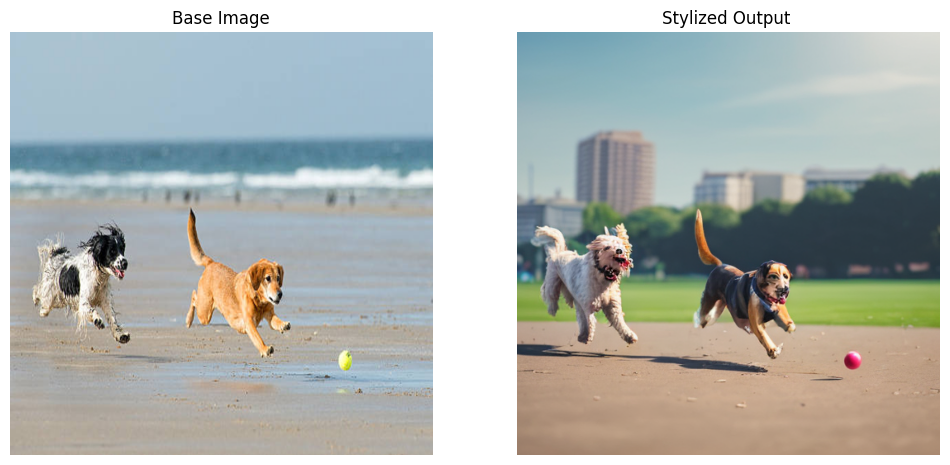

In [21]:


from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from controlnet_aux import CannyDetector
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch


torch.cuda.empty_cache()

drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/"
base_image_path = base_path + "dog.jpg"
style_image_path = base_path + "style.jpg"


def load_and_resize_local(path, size=(768, 768), mode="RGB"):
    return Image.open(path).convert(mode).resize(size)

base_image = load_and_resize_local(base_image_path)


controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)


pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "Yntec/AbsoluteReality",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")


pipe.enable_attention_slicing()

canny = CannyDetector()
edge_map = canny(base_image)
if isinstance(edge_map, np.ndarray):
    edge_map = Image.fromarray(edge_map)


prompt = "a playful dog chasing a ball in a sunny park, energetic and joyful atmosphere"


output = pipe(
    prompt=prompt,
    image=edge_map,
    num_inference_steps=30,
    guidance_scale=7.5
).images[0]


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(base_image)
plt.title("Base Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("Stylized Output ")
plt.axis("off")
plt.show()
